In [17]:
import os
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sqlalchemy import create_engine
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [18]:
# data
def get_data():
  engine_name = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
  engine = create_engine(engine_name)

  query_sql = "SELECT * FROM fb_data"
  df = pd.read_sql_query(query_sql, con=engine)
  return df

def process_text(text):
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('',text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def map_label_to_class(label):
  SOURCES = {
      0: ["nytimes","cnn","nbc"],
      1: ["FoxNews","DailyMail","NYPost"],
      2: ["bbcnews","Reuters","APNews"]
    }

  for class_label, sources in SOURCES.items():
      if label in sources:
          return class_label
  raise ValueError(f"Label '{label}' not found in any source categories.")


def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df['source'] = df['source'].apply(map_label_to_class)
  df.drop(columns=['id'])

  label_counts = df['source'].value_counts().sort_index()
  plt.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green'])
  plt.xticks(label_counts.index, ['left', 'right', 'center'])  
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Count of Labels')
  plt.show()

  return df


In [19]:
# dataset initialization
class FBData(Dataset):
  def __init__(self,df):

    tokenizer = get_tokenizer('basic_english')
    def yield_tokens(data_iter):
      for text in data_iter:
        yield tokenizer(text)
    vocab = build_vocab_from_iterator(yield_tokens(df['text']), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    
    df.drop(columns=['id'])
    
    self.data = df
    self.vocab = vocab
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]

    tokenized_text = self.vocab(self.tokenizer(text))

    return torch.tensor(tokenized_text),torch.tensor(label)

def collate_batch(batch):
  text_list=[]
  label_list=[]
  for text,label in batch:
    text_list.append(text)
    label_list.append(label)

  padded_texts = pad_sequence(text_list,batch_first=True,padding_value=0)
  return padded_texts, label_list

In [20]:
# model
class BiasClassificationModel(nn.Module):
  def __init__(self,input_size,embed_dim,hidden_dim_1,num_class):
    super(BiasClassificationModel,self).__init__()
    self.embed = nn.EmbeddingBag(input_size,embed_dim)
    self.fc1 = nn.Linear(embed_dim, hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1, num_class)
    self.relu = nn.LeakyReLU()
  
  def forward(self,text):
    embed = self.embed(text)
    output = self.relu(self.fc1(embed))
    output = self.fc2(output)
    return F.softmax(output,dim=1)

In [21]:
# split data 
def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  return train_loader, test_loader

In [22]:
# train and test
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()

    output = model(text)
    loss = criterion(output,label)
    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    loss.backward()
    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0
  test_preds = []
  test_labels = []

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)
      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()

      test_preds.extend(output.argmax(1).cpu().numpy())
      test_labels.extend(label.cpu().numpy())
      
  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss,test_acc, test_preds, test_labels

def train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc, test_preds, test_labels  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  print('Training Done, Final Testing Results Are As Shown:')

  print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
  0

  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()

  cm = confusion_matrix(test_preds, test_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  disp.plot(cmap='Blues')
  plt.title('Confusion Matrix: Predicted vs Actual Labels')
  plt.show()

In [23]:
def predict_text(text,dataset,model):
  text = process_text(text)
  tokenized_text = dataset.vocab(dataset.tokenizer(text))
  tokenized_text = torch.tensor(tokenized_text)

  tokenized_text = tokenized_text.unsqueeze(0)

  output = model(tokenized_text)
  prediction = output.argmax(1).item()

  if prediction == 0:
    prediction = 'left'
  elif prediction == 1:
    prediction = 'right'
  elif prediction == 2:
    prediction = 'center'
  else:
    raise ValueError(f"Prediction error.")

  print(f'The text provided leans towards the {prediction}')

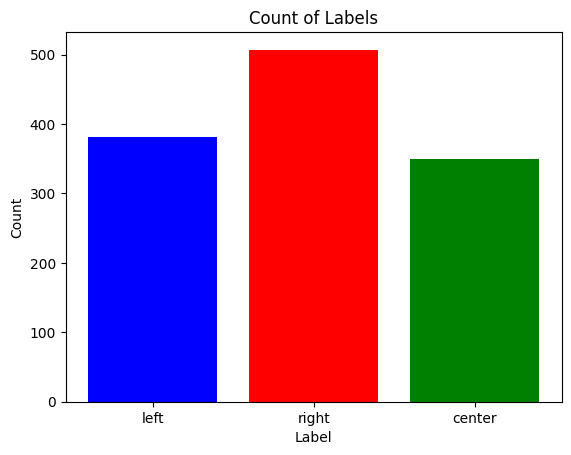

Training Starting


100%|██████████| 990/990 [00:03<00:00, 271.94it/s]


Training Epoch [1/5], Loss: 1.0290, Accuracy: 0.4697


100%|██████████| 248/248 [00:00<00:00, 2880.38it/s]


Test Epoch [1/5], Loss: 0.9533, Accuracy: 0.5524


100%|██████████| 990/990 [00:03<00:00, 309.22it/s]


Training Epoch [2/5], Loss: 0.8619, Accuracy: 0.7101


100%|██████████| 248/248 [00:00<00:00, 2880.19it/s]


Test Epoch [2/5], Loss: 0.8446, Accuracy: 0.7137


100%|██████████| 990/990 [00:03<00:00, 315.67it/s]


Training Epoch [3/5], Loss: 0.7225, Accuracy: 0.8606


100%|██████████| 248/248 [00:00<00:00, 2897.97it/s]


Test Epoch [3/5], Loss: 0.8142, Accuracy: 0.7177


100%|██████████| 990/990 [00:03<00:00, 282.26it/s]


Training Epoch [4/5], Loss: 0.6366, Accuracy: 0.9323


100%|██████████| 248/248 [00:00<00:00, 2897.26it/s]


Test Epoch [4/5], Loss: 0.7974, Accuracy: 0.7621


100%|██████████| 990/990 [00:03<00:00, 317.33it/s]


Training Epoch [5/5], Loss: 0.5951, Accuracy: 0.9677


100%|██████████| 248/248 [00:00<00:00, 2814.75it/s]

Test Epoch [5/5], Loss: 0.7936, Accuracy: 0.7460
Training Done, Final Testing Results Are As Shown:
Training Epoch [5/5], Loss: 0.5951, Accuracy: 0.9677


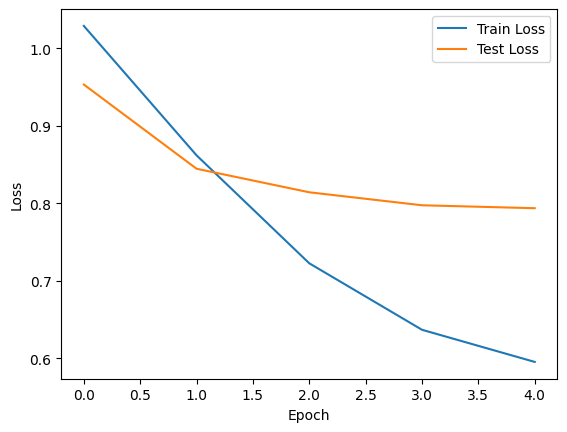

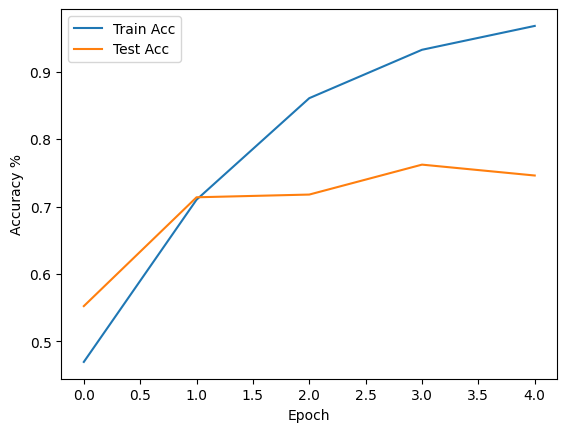

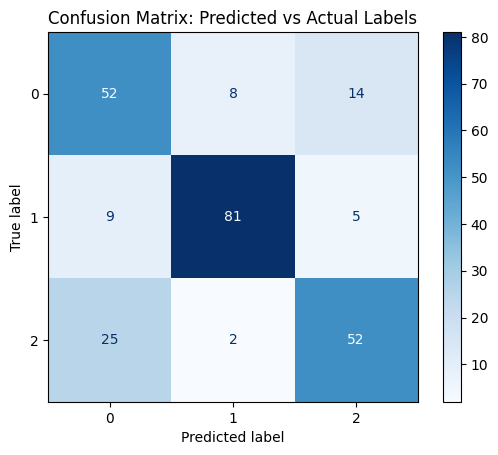

The text provided leans towards the left


In [24]:
def main(text,batch_size,num_epochs,verbose):
  df = get_data()
  df = process_data(df)
  
  dataset = FBData(df)

  model = BiasClassificationModel(len(dataset.vocab),64,32,3)
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
  criterion = torch.nn.CrossEntropyLoss()

  train_loader, test_loader = split_data(dataset,batch_size)
  train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)

  if(text is not None):
    predict_text(text,dataset,model)

text = "Breaking News: Hersh Goldberg-Polin, an American-Israeli who had been held in Gaza by Hamas for nearly 11 months, died in captivity, President Biden announced."
main(text,batch_size=1,num_epochs=5,verbose=True) 
  